# Stars Matching Project

In this project, we aim to match two images of stars by:
- Detecting stars in each image.
- Finding straight lines among the stars using the RANSAC algorithm.
- Building an affine transformation between the stars in the two images.
- Matching stars between the two images based on the transformation.
- Displaying the matches.


In [10]:
# Import libraries

import numpy as np  # Numerical computations, arrays, linear algebra
import cv2  # Image processing (OpenCV library)
from matplotlib import pyplot as plt  # Plotting images and graphs
from matplotlib.patches import ConnectionPatch  # Drawing lines between subplots (for matching points visualization)
from PIL import Image  # Opening and processing images (especially JPEG, PNG)
from pillow_heif import register_heif_opener  # Add support for opening HEIC images (iPhone photos)
import random  # Random sampling, useful for RANSAC point selection
import math  # Basic mathematical operations (sqrt, etc.)


In [11]:
# Functions for star detection
# This cell implements Part 2 of the assignment: Detecting stars and extracting (x, y, r, b).

def get_stars(image, size, param1=250, param2=1, min_r=2, max_r=6, desired_size=40):
    """
    Detects stars in a grayscale image using HoughCircles with adjustable parameters.

    Args:
        image: Grayscale image as a NumPy array.
        size: Tuple (width, height) for bounds checking.
        param1: First method-specific parameter for HoughCircles (higher threshold for Canny edge detector).
        param2: Second method-specific parameter for HoughCircles (accumulator threshold for circle centers).
        min_r: Minimum radius of circles to detect.
        max_r: Maximum radius of circles to detect.
        desired_size: Desired maximum number of detected stars.

    Returns:
        List of tuples (x, y, r, brightness) for each detected star.
    """
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 2, 20,
                               param1=param1, param2=param2, minRadius=min_r, maxRadius=max_r)

    if circles is not None:
        length = len(circles[0, :])
        if length > desired_size:
            for t in np.linspace(param2, param2+5, 6):  # Fine-tune param2
                circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                                           param1=param1, param2=t, minRadius=min_r, maxRadius=max_r)
                if circles is not None:
                    length = len(circles[0, :])
                    if length <= desired_size:
                        break

    if circles is None:
        return []

    circles = np.uint16(np.around(circles))
    circles_cordinates = []
    for i in circles[0, :]:
        if i[0] < size[0] and i[1] < size[1]:
            # (x, y, r, brightness)
            circles_cordinates.append(
                (int(i[0]), int(i[1]), i[2] + 5, int(image[i[1], i[0]])))

    return circles_cordinates

def save_stars_coordinates(output_path, stars):
    """
    Saves the detected star coordinates to a text file.

    Args:
        output_path: Path to save the output text file.
        stars: List of star tuples (x, y, r, brightness).
    """
    with open(output_path, "w") as f:
        f.write(f"x y r b\n")
        for star in stars:
            f.write(f"{star[0]} , {star[1]} , {star[2]} , {star[3]}\n")


Detected 16 stars in C:\Users\shifa\OneDrive\שולחן העבודה\EX1_NewSpace\test images\fr1.jpg:
x=385, y=353, r=10, brightness=96
x=465, y=195, r=10, brightness=71
x=537, y=5, r=10, brightness=30
x=571, y=471, r=9, brightness=77
x=145, y=531, r=9, brightness=98
x=303, y=185, r=9, brightness=83
x=407, y=87, r=9, brightness=52
x=537, y=29, r=9, brightness=36
x=343, y=563, r=8, brightness=95
x=151, y=3, r=10, brightness=45
x=535, y=433, r=10, brightness=77
x=541, y=257, r=10, brightness=67
x=429, y=321, r=8, brightness=96
x=489, y=397, r=10, brightness=84
x=489, y=191, r=9, brightness=69
x=505, y=355, r=9, brightness=76

Saved star detections to Detection_Results\fr1_detected.txt


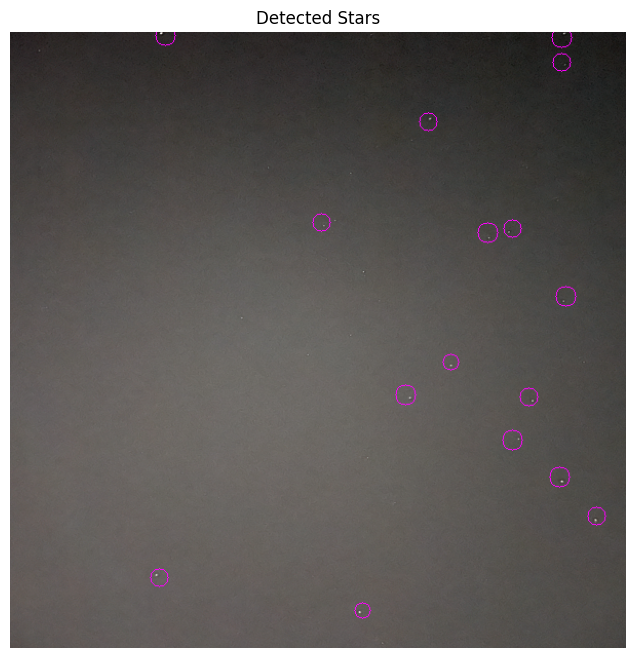

In [18]:

import os  # for creating folders

# Helper: open HEIC files support
register_heif_opener()

# Select an image filename (edit this string to choose your file)
image_path = "C:\\Users\\shifa\\OneDrive\\שולחן העבודה\\EX1_NewSpace\\test images\\fr1.jpg"  # <-- Change this to your image path

# Load and prepare the image
size = (600, 600)  # Resize target size
img = np.array(Image.open(image_path).resize(size))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect stars
stars = get_stars(img_gray, size)

# Output the results
print(f"Detected {len(stars)} stars in {image_path}:")
for star in stars:
    print(f"x={star[0]}, y={star[1]}, r={star[2]}, brightness={star[3]}")

# Create the folder for saving results if it does not exist
results_folder = "Detection_Results"
os.makedirs(results_folder, exist_ok=True)

# Create a filename for the output
image_name = os.path.basename(image_path).split(".")[0]
output_txt_path = os.path.join(results_folder, f"{image_name}_detected.txt")

# Save the stars to the text file
with open(output_txt_path, "w") as f:
    f.write("x y r b\n")
    for star in stars:
        f.write(f"{star[0]} {star[1]} {star[2]} {star[3]}\n")

print(f"\nSaved star detections to {output_txt_path}")

# Optional: Visualize the detected stars
for x, y, r, _ in stars:
    img = cv2.circle(img, (x, y), r, (255, 0, 255), 1)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Detected Stars")
plt.axis('off')
plt.show()


In [16]:
# Functions for matching stars between two images

def create_mapper(source, destination):
    """
    Creates an affine transformation mapper between two sets of points.

    Args:
        source: np.array of points from image 1.
        destination: np.array of points from image 2.

    Returns:
        A function that maps points from image 1 to image 2.
    """
    source = np.float32(source)
    destination = np.float32(destination)
    M = cv2.getAffineTransform(source, destination)

    def mapper(point):
        transformed_pt = np.dot(M, np.array([point[0], point[1], 1]))
        return (int(transformed_pt[0]), int(transformed_pt[1]))
    
    return mapper

def find_point(stars, source_point, mapped_point, e):
    """
    Finds a matching star close to the mapped point.

    Args:
        stars: List of detected stars in image 2.
        source_point: The original point from image 1.
        mapped_point: The point after transformation.
        e: Distance threshold for matching.

    Returns:
        The matching star, or None if not found.
    """
    x2, y2, r2, b2 = mapped_point

    for star in stars:
        x1, y1, r1, b1 = star
        dist_from_source = np.sqrt((source_point[0]-x2)**2 + (source_point[1]-y2)**2)
        dist_s = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        
        if dist_s < e and abs(r1 - r2) < 6:
            return star
    
    return None

def count_inliers(stars1, stars2, T, e=16):
    """
    Counts how many stars are mapped correctly between two images.

    Args:
        stars1: List of stars in image 1.
        stars2: List of stars in image 2.
        T: Transformation function.
        e: Distance threshold.

    Returns:
        Number of matched stars (inliers).
    """
    cnt = 0
    matchings = {}

    for star in stars1:
        x, y, r, b = star
        mapped_point = T((x, y))
        matched_star = find_point(stars2, star, (mapped_point[0], mapped_point[1], r, b), e)
        
        matchings[matched_star] = matchings.get(matched_star, 0) + 1

        if matched_star is not None and matchings[matched_star] <= 1:
            cnt += 1
    
    return cnt

def matching_ratio(set_1, set_2, inliers_count):
    """
    Computes the ratio of matched points to the minimum size of the two sets.

    Args:
        set_1: Stars in image 1.
        set_2: Stars in image 2.
        inliers_count: Number of matched stars.

    Returns:
        Matching ratio as a float.
    """
    length = min(len(set_1), len(set_2))
    return inliers_count / length


Detected 16 stars in Image 1
Detected 16 stars in Image 2

Best Matching Ratio: 0.75


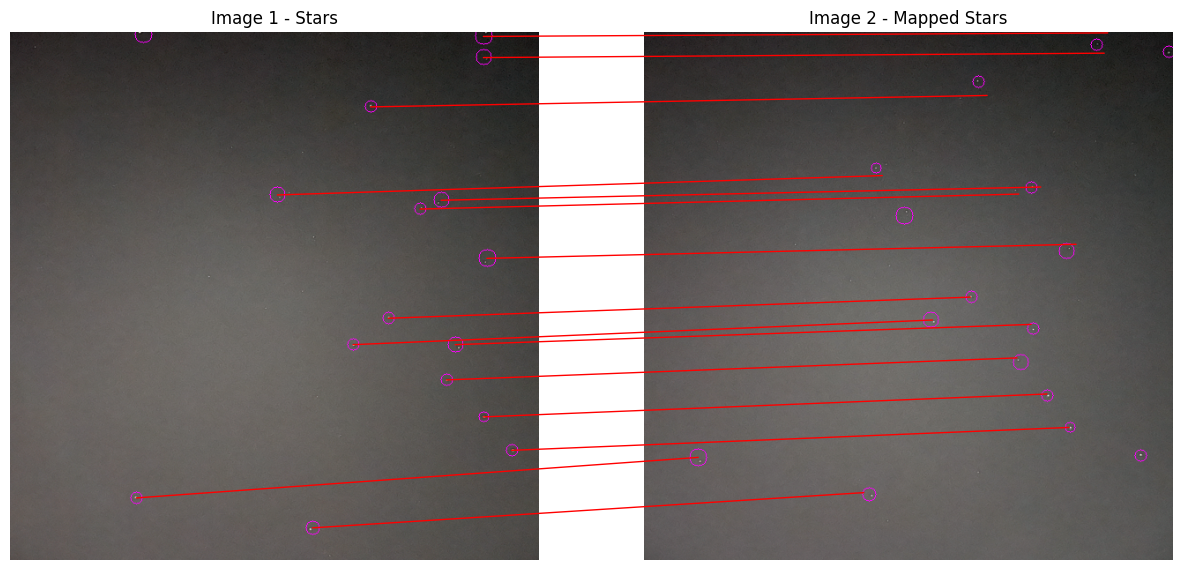

In [19]:
# Matching with real RANSAC search over affine transforms

def best_match_mapper(points1, points2, iterations=2000, e=16):
    """
    Tries many 3-point mappings and returns the one with the most inliers.

    Args:
        points1: stars in image 1 (list of (x, y, r, b)).
        points2: stars in image 2 (list of (x, y, r, b)).
        iterations: number of random trials.
        e: distance threshold for inlier.

    Returns:
        best_mapper: function that maps points from image 1 to image 2.
        best_ratio: best matching ratio found.
        best_matched: list of point pairs (img1, mapped point).
        src_points, dst_points: the best three points used for the transform.
    """
    best_mapper = None
    best_ratio = -1
    best_matched = []
    best_src, best_dst = None, None

    for _ in range(iterations):
        try:
            src = random.sample(points1, 3)
            dst = random.sample(points2, 3)

            mapper = create_mapper(
                [(p[0], p[1]) for p in src],
                [(p[0], p[1]) for p in dst]
            )

            count = count_inliers(points1, points2, mapper, e)
            ratio = matching_ratio(points1, points2, count)

            if ratio > best_ratio:
                best_ratio = ratio
                best_mapper = mapper
                best_src = src
                best_dst = dst

                best_matched = [[(p[0], p[1]), mapper((p[0], p[1]))] for p in points1]

        except Exception:
            continue

    return best_mapper, best_ratio, best_matched, best_src, best_dst



# Helper
register_heif_opener()

# paths to images
image_path1 = "C:\\Users\\shifa\\OneDrive\\שולחן העבודה\\EX1_NewSpace\\test images\\fr1.jpg"
image_path2 = "C:\\Users\\shifa\\OneDrive\\שולחן העבודה\\EX1_NewSpace\\test images\\fr2.jpg"
size = (600, 600)

img1 = np.array(Image.open(image_path1).resize(size))
img2 = np.array(Image.open(image_path2).resize(size))
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# detect stars
stars1 = get_stars(img1_gray, size, param2=0.8, min_r=1, max_r=6)
stars2 = get_stars(img2_gray, size, param2=0.8, min_r=1, max_r=6)
print(f"Detected {len(stars1)} stars in Image 1")
print(f"Detected {len(stars2)} stars in Image 2")

#find the best mathcing
random.seed(42)
best_T, best_ratio, mapped_stars, src_pts, dst_pts = best_match_mapper(stars1, stars2, iterations=2000, e=16)
print(f"\nBest Matching Ratio: {best_ratio:.2f}")

# draw
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


for x, y, r, _ in stars1:
    img1 = cv2.circle(img1, (x, y), r, (255, 0, 255), 1)
for x, y, r, _ in stars2:
    img2 = cv2.circle(img2, (x, y), r, (255, 0, 255), 1)


for s, d in mapped_stars:
    con = ConnectionPatch(xyA=s, xyB=d, coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red")
    ax2.add_artist(con)

ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title("Image 1 - Stars")
ax1.axis("off")

ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title("Image 2 - Mapped Stars")
ax2.axis("off")

plt.show()


In [9]:
import os
from itertools import combinations
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# === Configuration ===
folder_path = "C:/Users/shifa/OneDrive/שולחן העבודה/EX1_NewSpace/test images"
size = (600, 600)
output_folder = "Mapping_Results"
os.makedirs(output_folder, exist_ok=True)

# === Get list of image files (.jpg and .png)
image_files = [str(f) for f in Path(folder_path).glob("*.jpg")] + \
              [str(f) for f in Path(folder_path).glob("*.png")]

# === Loop through all unique image pairs ===
for img1_path, img2_path in combinations(image_files, 2):
    try:
        # --- Load and resize the images ---
        img1 = np.array(Image.open(img1_path).resize(size))
        img2 = np.array(Image.open(img2_path).resize(size))
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        # --- Detect stars in each image ---
        stars1 = get_stars(img1_gray, size, param2=0.8, min_r=1, max_r=6)
        stars2 = get_stars(img2_gray, size, param2=0.8, min_r=1, max_r=6)

        print(f"🔄 Comparing: {os.path.basename(img1_path)} <-> {os.path.basename(img2_path)}")

        # --- Run affine transformation matching ---
        best_T, _, mapped_stars, src_pts, dst_pts = best_match_mapper(
            stars1, stars2, iterations=2000, e=16)

        # --- Save results in .txt (without ratio) ---
        pair_name = f"{Path(img1_path).stem}__{Path(img2_path).stem}"
        result_path = os.path.join(output_folder, f"{pair_name}_result.txt")

        with open(result_path, "w") as f:
            f.write(f"Image 1: {os.path.basename(img1_path)}\n")
            f.write(f"Image 2: {os.path.basename(img2_path)}\n")
            f.write(f"Stars detected: {len(stars1)} (img1), {len(stars2)} (img2)\n")
            f.write(f"Source (img1) points used: {src_pts}\n")
            f.write(f"Destination (img2) points used: {dst_pts}\n")

        # --- Draw star locations on the images ---
        img1_draw = img1.copy()
        img2_draw = img2.copy()
        for x, y, r, _ in stars1:
            img1_draw = cv2.circle(img1_draw, (x, y), r, (255, 0, 255), 1)
        for x, y, r, _ in stars2:
            img2_draw = cv2.circle(img2_draw, (x, y), r, (255, 0, 255), 1)

        # --- Connect matched stars ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        for s, d in mapped_stars:
            con = ConnectionPatch(xyA=s, xyB=d, coordsA="data", coordsB="data",
                                  axesA=ax1, axesB=ax2, color="red")
            ax2.add_artist(con)

        ax1.imshow(cv2.cvtColor(img1_draw, cv2.COLOR_BGR2RGB))
        ax1.set_title(f"{os.path.basename(img1_path)}")
        ax1.axis("off")

        ax2.imshow(cv2.cvtColor(img2_draw, cv2.COLOR_BGR2RGB))
        ax2.set_title(f"{os.path.basename(img2_path)}")
        ax2.axis("off")

        # --- Save the output figure ---
        fig_path = os.path.join(output_folder, f"{pair_name}_matched.png")
        plt.savefig(fig_path)
        plt.close()

    except Exception as e:
        print(f"⚠️ Error comparing {img1_path} <-> {img2_path}: {e}")


🔄 Comparing: fr1.jpg <-> fr2.jpg
🔄 Comparing: fr1.jpg <-> ST_db1.png
🔄 Comparing: fr1.jpg <-> ST_db2.png
🔄 Comparing: fr2.jpg <-> ST_db1.png
🔄 Comparing: fr2.jpg <-> ST_db2.png
🔄 Comparing: ST_db1.png <-> ST_db2.png
